# SWOP script 5 - Linear Mixed Effects Analysis
## 700-900 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [12]:
date()

[1] "Tue Aug 31 15:43:18 2021"

In [13]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)

## Set parameters for this analysis

In [14]:
component = '700-900'
expt = 'SWOP'
data_path = '../group_data/'
out_path = '../results/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 15

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [15]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [16]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [17]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [18]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6314   Min.   :   1157   V2/hemma :20800   L_Post :18766  
 s_09lo : 6292   1st Qu.: 501778   V2/idag  :20578   L_Cent :18724  
 s_18ak : 6289   Median :1073114   V2/kanske:20778   R_Cent :18632  
 s_21ma : 6277   Mean   :1098034   V3/hemma :20774   R_Post :18546  
 s_12wg : 6264   3rd Qu.:1655284   V3/idag  :20698   R_Ant  :18542  
 s_07ba : 6263   Max.   :2977152   V3/kanske:20781   L_Ant  :18486  
 (Other):86710                                       (Other):12713  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 P7     : 4785   206    :   537   0.0:20565   N:62274      0: 20011           
 TP8    : 4783   243    :   536   1.0:22859   P:62135      1:104398           
 TP7    : 4782   467    :   536   2.0:17158                                   
 T8     : 4775   116    :   535   3.0:24762                                   
 T7     : 4766   73     :   535   4.0:22235          

In [19]:
str(dat)

'data.frame':	124409 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [20]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                681   686  697
V2                680   701  682

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 4127 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.33, df = 2, p-value = 0.85

### Visualize distributions

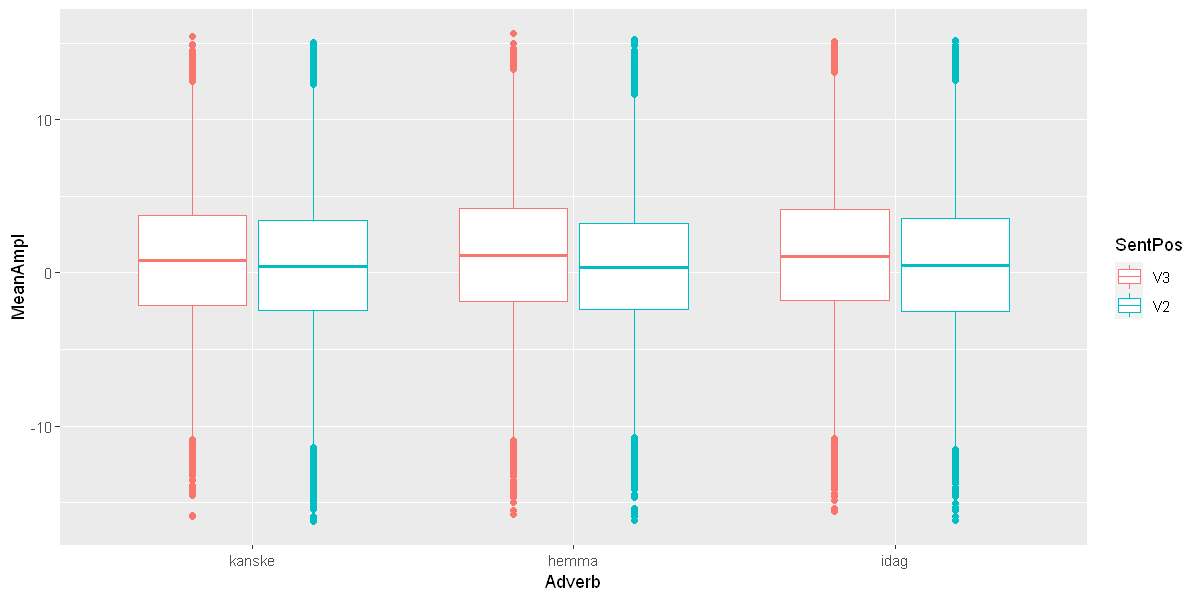

In [21]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [11]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)


Method: fREML   Optimizer: perf newton
full convergence after 7 iterations.
Gradient range [-0.0040453,0.000000026895]
(score 364592 & scale 20.529).
Hessian positive definite, eigenvalue range [9.3393,62178].
Model rank =  74 / 74 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k'  edf k-index p-value
s(Subject) 20.0 18.8      NA      NA


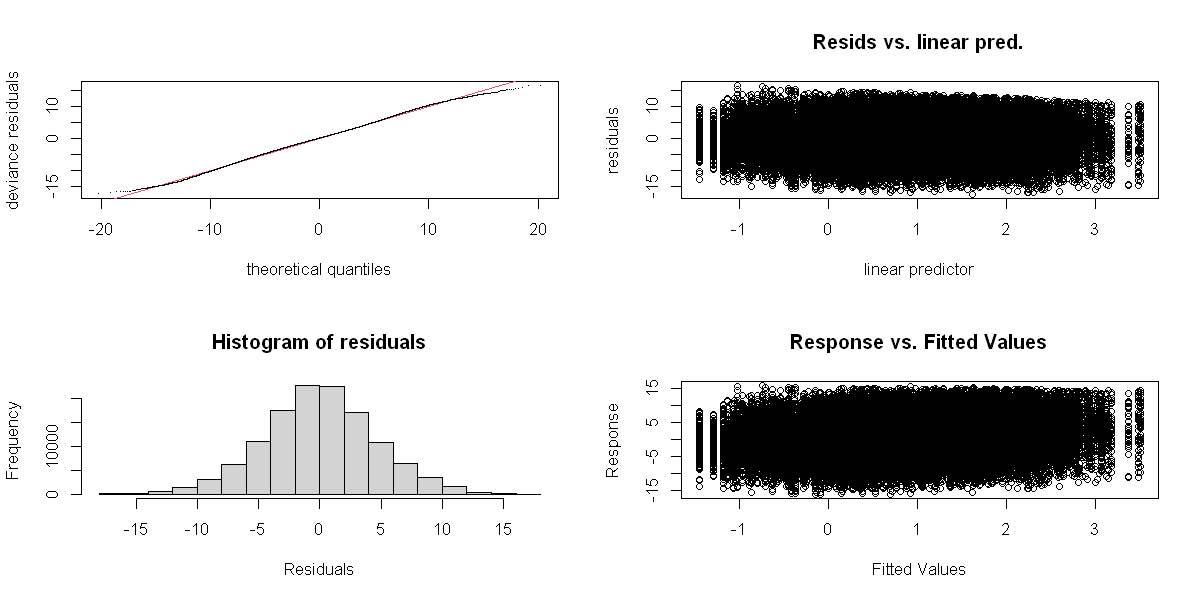

In [12]:
gam.check(m0)

In [13]:
anova(m0)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb * SentPos * ROI) + s(Subject, bs = "re")

Parametric Terms:
                   df     F              p-value
Adverb              2  1.03                 0.36
SentPos             1 25.70          0.000000400
ROI                 8 53.98 < 0.0000000000000002
Adverb:SentPos      2  0.37                 0.69
Adverb:ROI         16  1.07                 0.38
SentPos:ROI         8  6.71          0.000000008
Adverb:SentPos:ROI 16  0.99                 0.46

Approximate significance of smooth terms:
            edf Ref.df   F             p-value
s(Subject) 18.8   19.0 118 <0.0000000000000002

## Include baseline as fixed effect, not interacting with other factors

In [14]:
cl <- makeCluster(num_cores)  

m_b_nox <- bam(MeanAmpl ~ (Adverb * SentPos * ROI) + baseline
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Include baseline as a fixed effect, *fully interacting* with other factors

In [15]:
cl <- makeCluster(num_cores)  

m_full <- bam(MeanAmpl ~ (Adverb * SentPos * ROI * baseline)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Add random intercepts for items (sentences) as well as subjects

In [16]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Allow only 3-way interactions

In [17]:
cl <- makeCluster(num_cores)  

mf_3w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 4 way interactions

This takes a long time to fit, and requires lots of RAM

In [22]:
cl <- makeCluster(num_cores)  

mf_4w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 3 way interactions

In [19]:
cl <- makeCluster(num_cores)  

mf_3w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Random intercepts by item, not nested in subjects

In [20]:
cl <- makeCluster(num_cores)  

mf_4w_reci <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [21]:
AICtab <- as.data.frame(AIC(m0, m_full, m_b_nox, 
                            mf_3w_rei, mf_3w_recsis,
                            mf_4w_rei, mf_4w_recsis, mf_4w_reci
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

,df,AIC,deltaAIC
,<dbl>,<dbl>,<dbl>
mf_4w_recsis,5206.617,640382,0.0000
mf_3w_recsis,5190.606,640385,2.4275
mf_4w_reci,811.668,718221,77838.6053
mf_3w_rei,332.562,720917,80535.1012
mf_4w_rei,348.569,720934,80552.1282
m_full,127.818,723860,83477.7952
m_b_nox,74.819,723907,83524.9367
m0,73.857,729077,88695.0469


---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [22]:
anova(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric Terms:
                            df      F              p-value
Adverb                       2   0.27               0.7667
SentPos                      1  15.36             0.000089
ROI                          8  33.10 < 0.0000000000000002
baseline                     1 176.74 < 0.0000000000000002
Adverb:SentPos               2   0.31               0.7342
Adverb:ROI                  16   2.94             0.000069
Adverb:baseline              2   0.06               0.9415
SentPos:ROI                  8  15.50 < 0.0000000000000002
SentPos:baseline             1   8.09               0.0044
ROI:baseline                 8   0.56               0.8136
Adverb:SentPos:ROI          16   2.75               0.0002
Adverb:SentPos:baseline      2   1.09               0.3369
Adverb:ROI:baseline         16   0.95  

### Write ANOVA table to text file

In [23]:
capture.output(anova(mf_4w_recsis), file=paste(out_path, 'anova_table_', component, '.txt'))

In [23]:
summary(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric coefficients:
                                          Estimate Std. Error t value
(Intercept)                               1.310033   0.153897    8.51
Adverbhemma                               0.093593   0.177602    0.53
Adverbidag                                0.124016   0.177293    0.70
SentPosV2                                -0.696125   0.177624   -3.92
ROIM_Ant                                  0.185037   0.238390    0.78
ROIR_Ant                                  0.126644   0.149856    0.85
ROIL_Cent                                -0.771173   0.149075   -5.17
ROIM_Cent                                 0.490673   0.240224    2.04
ROIR_Cent                                -0.390610   0.149573   -2.61
ROIL_Post                                -1.760233   0.149150  -11.80
ROIM_Post                    

### View the model that gives best AIC, within computational feasibility

In [24]:
mod = mf_4w_rei #mf_4w_rei

In [25]:
anova(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric Terms:
                            df      F              p-value
Adverb                       2   0.89                0.412
SentPos                      1  30.07         0.0000000417
ROI                          8  52.16 < 0.0000000000000002
baseline                     1 112.05 < 0.0000000000000002
Adverb:SentPos               2   1.80                0.166
Adverb:ROI                  16   1.17                0.281
Adverb:baseline              2   1.85                0.157
SentPos:ROI                  8   7.00         0.0000000028
SentPos:baseline             1   1.08                0.299
ROI:baseline                 8   1.17                0.311
Adverb:SentPos:ROI          16   1.39                0.133
Adverb:SentPos:baseline      2   2.39                0.091
Adverb:ROI:baseline         16   0.66                0.83

In [26]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric coefficients:
                                         Estimate Std. Error t value
(Intercept)                               1.23673    0.16516    7.49
Adverbhemma                               0.14399    0.15923    0.90
Adverbidag                                0.20616    0.15869    1.30
SentPosV2                                -0.62332    0.11367   -5.48
ROIM_Ant                                  0.09713    0.18382    0.53
ROIR_Ant                                  0.10402    0.11387    0.91
ROIL_Cent                                -0.79772    0.11186   -7.13
ROIM_Cent                                 0.23582    0.18825    1.25
ROIR_Cent                                -0.43460    0.11308   -3.84
ROIL_Post                                -1.72544    0.11194  -15.41
ROIM_Post                                -0.14038    0.185

## View results

In [27]:
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



,contrast,Adverb,ROI,estimate,SE,df,t.ratio,p (raw),p (FDR BH)
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V3 - V2,kanske,L_Ant,0.59770,0.11192,124062,5.34025,0.0000,0.0000
2,V3 - V2,hemma,L_Ant,0.70029,0.11188,124062,6.25906,0.0000,0.0000
3,V3 - V2,idag,L_Ant,0.84172,0.11257,124062,7.47761,0.0000,0.0000
4,V3 - V2,kanske,M_Ant,0.57387,0.23183,124062,2.47532,0.0133,0.0163
5,V3 - V2,hemma,M_Ant,0.47301,0.23229,124062,2.03634,0.0417,0.0490
6,V3 - V2,idag,M_Ant,0.86585,0.23429,124062,3.69558,0.0002,0.0003
7,V3 - V2,kanske,R_Ant,0.56198,0.11203,124062,5.01616,0.0000,0.0000
8,V3 - V2,hemma,R_Ant,0.77276,0.11192,124062,6.90479,0.0000,0.0000
9,V3 - V2,idag,R_Ant,0.91688,0.11267,124062,8.13766,0.0000,0.0000


## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

Since 'object' is a list, we are using the contrasts already present.



png 
  2

Since 'object' is a list, we are using the contrasts already present.



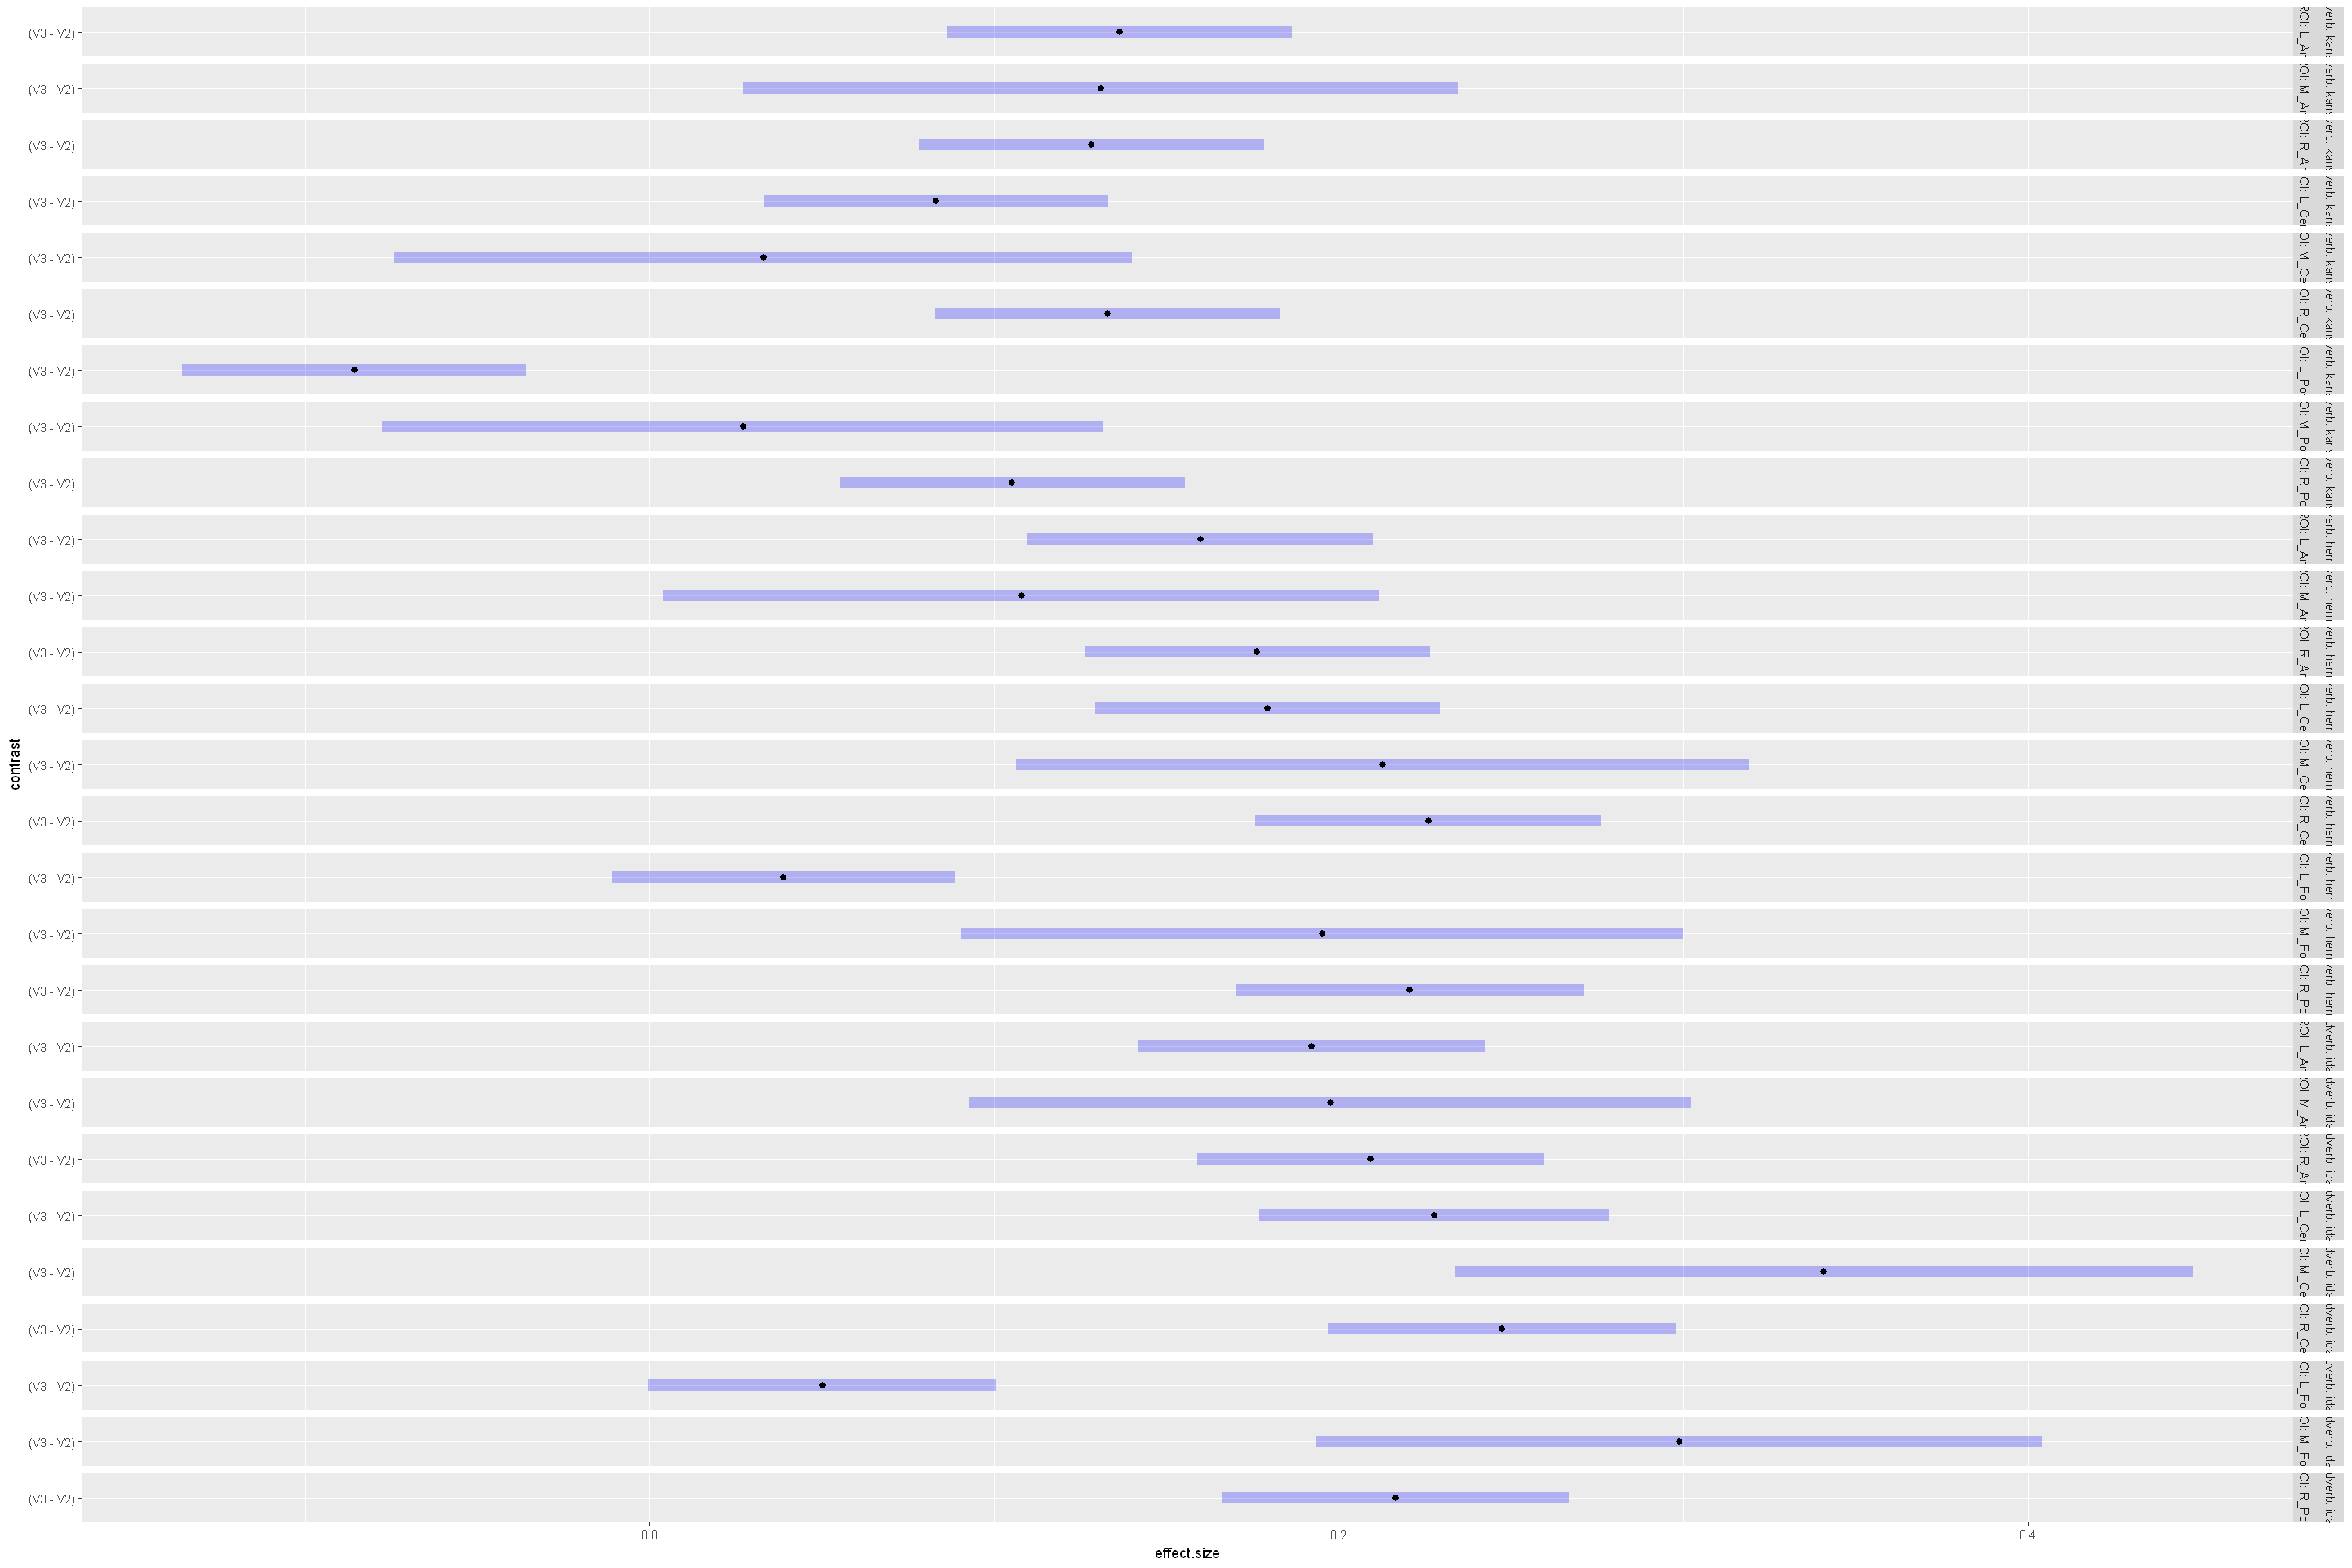

In [28]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [29]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

Since 'object' is a list, we are using the contrasts already present.



contrast.ctr,Adverb,ROI,estimate,SE.ctr,df.ctr,t.ratio,p (raw),p (FDR BH),contrast.eff,effect.size,SE.eff,df.eff,lower.CL,upper.CL
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V3 - V2,kanske,L_Ant,0.59770,0.11192,124062,5.34025,0.0000,0.0000,(V3 - V2),0.136443,0.025551,124062,0.08636261,0.186523
V3 - V2,hemma,L_Ant,0.70029,0.11188,124062,6.25906,0.0000,0.0000,(V3 - V2),0.159862,0.025543,124062,0.10979856,0.209926
V3 - V2,idag,L_Ant,0.84172,0.11257,124062,7.47761,0.0000,0.0000,(V3 - V2),0.192149,0.025699,124062,0.14177835,0.242519
V3 - V2,kanske,M_Ant,0.57387,0.23183,124062,2.47532,0.0133,0.0163,(V3 - V2),0.131003,0.052924,124062,0.02727238,0.234734
V3 - V2,hemma,M_Ant,0.47301,0.23229,124062,2.03634,0.0417,0.0490,(V3 - V2),0.107980,0.053027,124062,0.00404795,0.211912
V3 - V2,idag,M_Ant,0.86585,0.23429,124062,3.69558,0.0002,0.0003,(V3 - V2),0.197657,0.053486,124062,0.09282511,0.302489
V3 - V2,kanske,R_Ant,0.56198,0.11203,124062,5.01616,0.0000,0.0000,(V3 - V2),0.128288,0.025576,124062,0.07815929,0.178418
V3 - V2,hemma,R_Ant,0.77276,0.11192,124062,6.90479,0.0000,0.0000,(V3 - V2),0.176407,0.025551,124062,0.12632794,0.226487
V3 - V2,idag,R_Ant,0.91688,0.11267,124062,8.13766,0.0000,0.0000,(V3 - V2),0.209307,0.025724,124062,0.15888775,0.259726


### Write above table to file

In [30]:
write.csv(full_tab, file=paste(out_path, 'contrast_table_', component, '.csv' ,sep=''))

## Plot Model

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



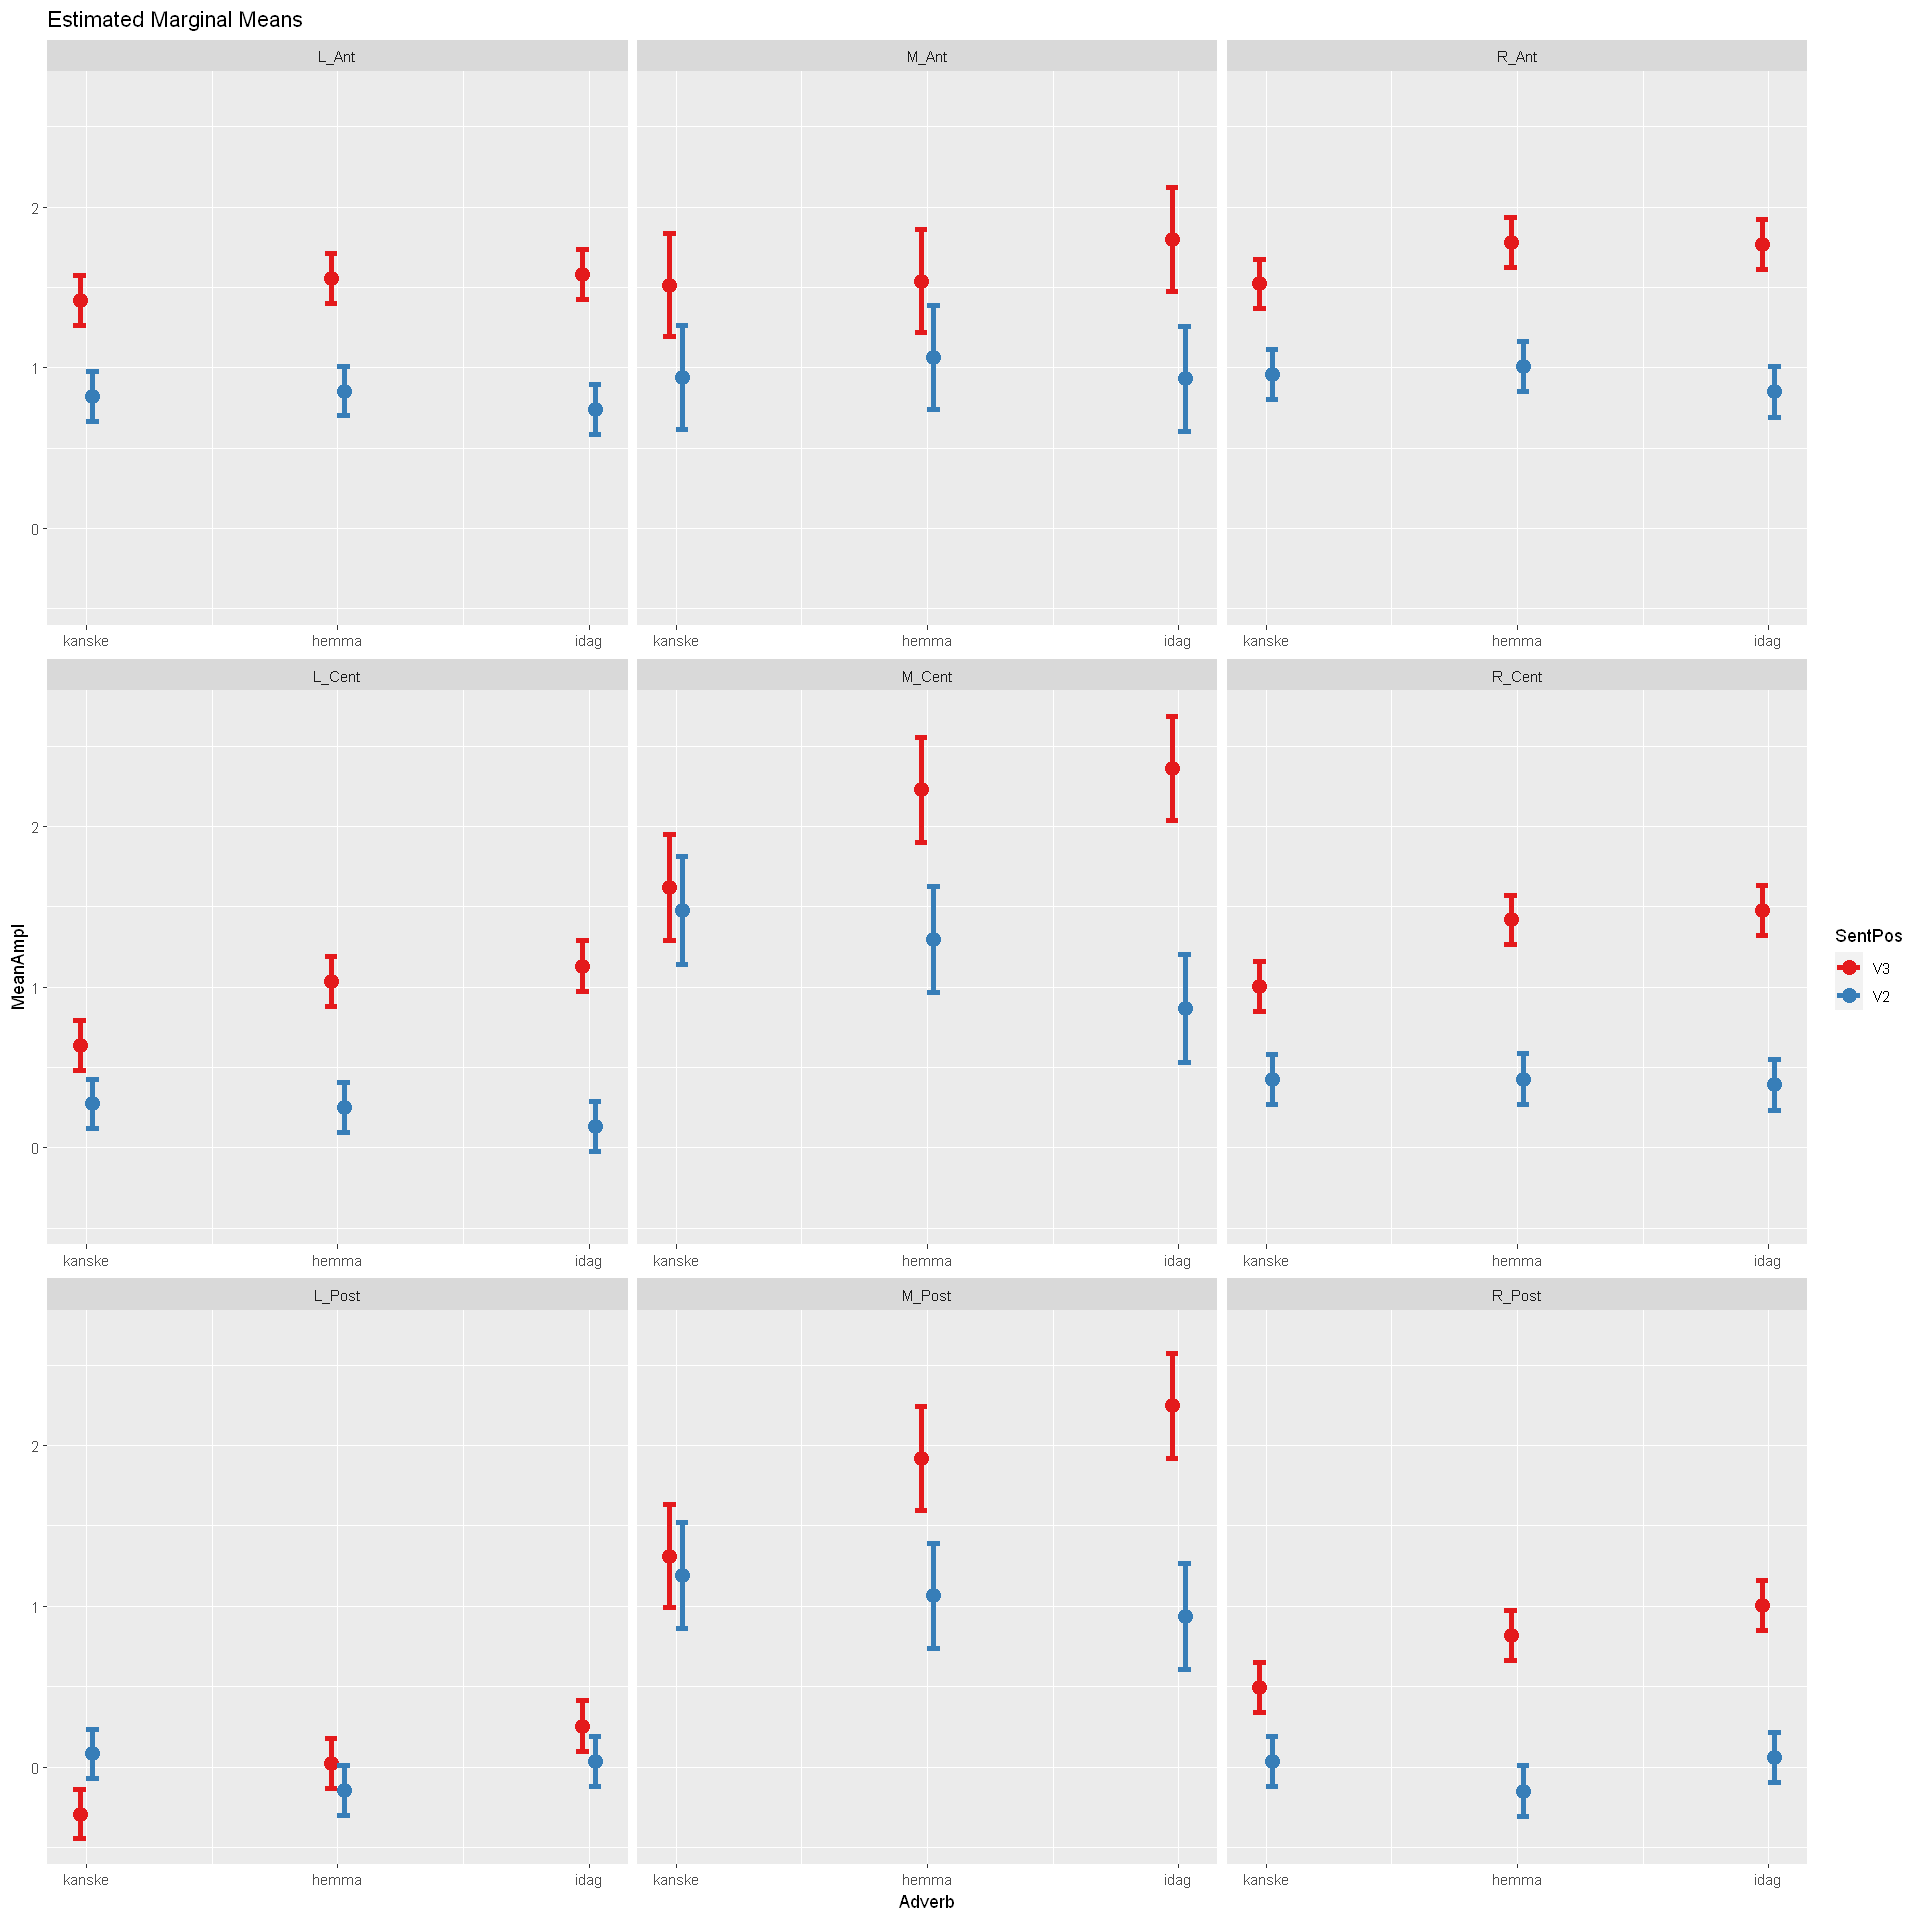

In [31]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [32]:
date()

[1] "Sun Aug 29 02:37:50 2021"

# Do with recsis model

In [ ]:
mod <- mf_4w_recsis
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

In [ ]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [ ]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

### Write above table to file

In [ ]:
# write.csv(full_tab, file=paste(out_path, 'contrast_table_', component, '.csv' ,sep=''))

## Plot Model

In [ ]:
# save PDF
# pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '.pdf', sep="")) 
# plot_model(mod, 
#            type='emm',
#            terms=c('Adverb', 'SentPos', 'ROI'),
#            dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
#            title='Estimated Marginal Means'
#           )
# dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [ ]:
date()